In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint
import matplotlib.dates as mdates
import pandas as pd

data = pd.read_csv("sg_final.csv")

In [3]:
# get the data for the second outbreak (2021-09-01 to 2021-10-31)
data = data[data['Date'] >= '2021-09-01']
i = data['Intensive Care Unit (ICU)'] + data['General Wards MOH report'] + data['In Isolation MOH report']
r = data['Cumulative Confirmed']- i - data['Cumulative Deaths']
d = data['Cumulative Deaths']
h = data['Intensive Care Unit (ICU)'] + data['General Wards MOH report']
l = i - h

# measure the influence of policy
mobile = (data['retail_and_recreation']+data['grocery_and_pharmacy']+data['residential']+data['transit_stations']+data['parks']+data['workplaces'])/6

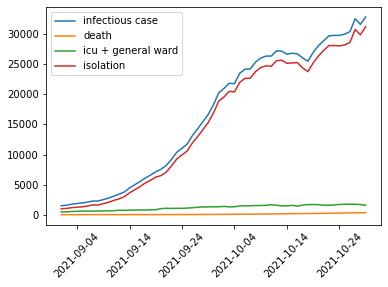

In [9]:
# plot datas for every states in SIR model
import matplotlib.dates as mdates
period = len(i)
t = data['Date']
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.xticks(rotation = 45)
plt.plot(t,i,label='infectious case')
#plt.plot(t,r,label='r')
plt.plot(t,d,label='death')
plt.plot(t,h,label='icu + general ward')
plt.plot(t,l,label='isolation')
plt.legend()
plt.savefig('after vaccine all.jpg')

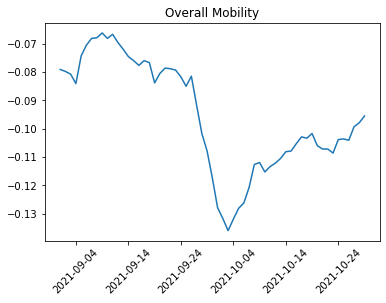

In [10]:
# plot the mobility
t_t = data['Date']
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.plot(t_t, mobile/100)
plt.xticks(rotation = 45)
plt.title('Overall Mobility')
plt.savefig('mobility after.jpg',bbox_inches = 'tight')

In [33]:
# SIR differential model
def f(y, t, paras):
    """
    Your system of differential equations
    """

    s = y[0] 
    i = y[1]
    d = y[2]
    h = y[3]
    r = y[4]
    
    t1 = int(min(t + mobile.idxmin(), mobile.idxmax()))


    try:
        beta = paras['k0'].value
        gamma = paras['k1'].value
        p_h = paras['k2'].value
        r_d = paras['k3'].value
    except KeyError:
        beta, gamma,p_h,r_d = paras

    # the model equations
    s = max(0, s)
    s1 = -beta * s / 110000 * i * (1 + mobile[t1]/100) 
    i1 = -s1 - gamma * i - i * r_d
    d1 = i * r_d 
    h1 = i1 * p_h
    r1 = gamma * i 
    return [s1,i1,d1,h1,r1]

# ODE model
def g(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, (paras,))
    return x

In [40]:
# residual function
def residual(paras, t, data):

    """
    compute the residual between actual data and fitted data
    """

    x0 = paras['s'].value, paras['i'].value, paras['d'].value, paras['h'].value, paras['r'].value
    model = g(t, x0, paras)
    return (model[:,p_index] - data[p_index - 1]).ravel()

# fit function
def fit_i():
    plt.figure()
    t_t = data['Date']
    plt.scatter(t_t,measured[p_index - 1], marker='o', color='g', s=5, label = 'measured')
    result = minimize(residual, params, args=(t_x, measured), method='leastsq')  # leastsq nelder
    # check results of the fit
    data_fitted = g(t_x, x0, result.params)
    # plot measured data
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
    plt.xticks(rotation = 45)
    # plot fitted data
    plt.plot(t_t, data_fitted[:, p_index], '-', linewidth=2, color='red', label='fitted')
    report_fit(result)
    plt.legend()
    plt.savefig('after fit',)
    return data_fitted

In [13]:
# set the initial parameters
indmin = i.index[0]
i0 = i[indmin]
d0 = d[indmin]
h0 = h[indmin]
r0 = r[indmin]
s0 = 90000

x0 = [s0,i0,d0,h0,r0]
t_x = np.arange(0, period)
measured = [i,d,h,r]

params = Parameters()
params.add('s', value=s0, vary=False)
params.add('i', value=i0, vary=False)
params.add('d', value=d0, vary=False)
params.add('h', value=h0, vary=False)
params.add('r', value=r0, vary=False)
params.add('k0', value=0.45, min=0.00001, max=0.5)
params.add('k1', value=0.1, min=0.00001, max=0.7)
params.add('k2', value = 8/100, min = 1/100, max = 0.2)
params.add('k3', value = 1/100, min = 0.001/100, max = 0.1)




59
59
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 59
    # variables        = 4
    chi-square         = 1.3549e+08
    reduced chi-square = 2463516.47
    Akaike info crit   = 872.166869
    Bayesian info crit = 880.477019
##  Warning: uncertainties could not be estimated:
    k2:  at initial value
[[Variables]]
    s:   90000 (fixed)
    i:   1523 (fixed)
    d:   55 (fixed)
    h:   499 (fixed)
    r:   66222 (fixed)
    k0:  0.18322830 (init = 0.1460235)
    k1:  0.04446609 (init = 0.1)
    k2:  0.08000000 (init = 0.08)
    k3:  1.0025e-04 (init = 0.00015667)


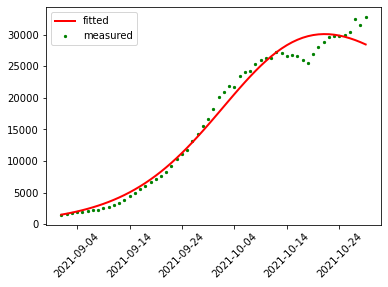

In [47]:
# fit I curve
p_index = 1
df = fit_i()

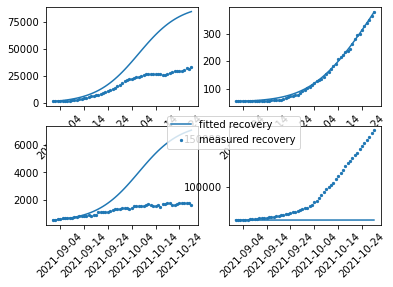

In [53]:
t_t = data['Date']
plt.subplot(221)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.xticks(rotation = 45)
plt.scatter(t_t,measured[0], marker='o', s=5, label = 'measured infectious')
plt.plot(t_t, df[:,1],label = 'fitted infectious')
plt.subplot(222)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.xticks(rotation = 45)
plt.scatter(t_t,measured[1], marker='o', s=5, label = 'measured death')
plt.plot(t_t, df[:,2],label = 'fitted death')
plt.subplot(223)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.xticks(rotation = 45)
plt.scatter(t_t,measured[2], marker='o', s=5, label = 'measured hospitized')
plt.plot(t_t, df[:,3],label = 'fitted hospitized')
plt.subplot(224)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.xticks(rotation = 45)
plt.scatter(t_t,measured[3], marker='o', s=5, label = 'measured recovery')
plt.plot(t_t, df[:,4],label = 'fitted recovery')
plt.legend(bbox_to_anchor=(0.5, 1.15),)
plt.savefig('after fit all.jpg',bbox_inches = 'tight')

In [35]:
indmin = i.index[0]
i0 = i[indmin]
d0 = d[indmin]
h0 = h[indmin]
r0 = r[indmin]
s0 = 90000

x0 = [s0,i0,d0,h0,r0]
# measured data
t_x = np.arange(0, period)
measured = [i,d,h,r]

params = Parameters()
params.add('s', value=s0, vary=False)
params.add('i', value=i0, vary=False)
params.add('d', value=d0, vary=False)
params.add('h', value=h0, vary=False)
params.add('r', value=r0, vary=False)
params.add('k0', value=0.18322612, min=0.00001, max=0.5)
params.add('k1', value=0.1, min=0.00001, max=0.7)
params.add('k2', value = 8/100, min = 1/100, max = 0.2)
params.add('k3', value = 1/100, min = 0.001/100, max = 0.1)



59
59
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 113
    # data points      = 59
    # variables        = 4
    chi-square         = 1013.94154
    reduced chi-square = 18.4353007
    Akaike info crit   = 175.799722
    Bayesian info crit = 184.109872
##  Warning: uncertainties could not be estimated:
    k0:  at initial value
    k1:  at boundary
    k2:  at initial value
    k3:  at initial value
[[Variables]]
    s:   90000 (fixed)
    i:   1523 (fixed)
    d:   55 (fixed)
    h:   499 (fixed)
    r:   66222 (fixed)
    k0:  0.14602370 (init = 0.1460235)
    k1:  1.0000e-05 (init = 0.1)
    k2:  0.08000000 (init = 0.08)
    k3:  1.5667e-04 (init = 0.00015667)


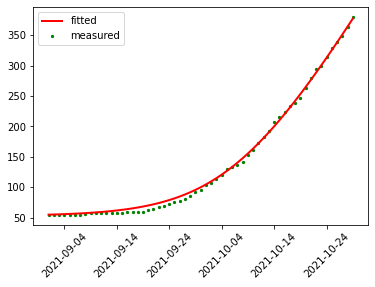

In [52]:
# fit D curve
p_index = 2
df = fit_i()

59
59
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 88
    # data points      = 59
    # variables        = 4
    chi-square         = 261830.482
    reduced chi-square = 4760.55422
    Akaike info crit   = 503.476992
    Bayesian info crit = 511.787142
[[Variables]]
    s:   90000 (fixed)
    i:   1523 (fixed)
    d:   55 (fixed)
    h:   499 (fixed)
    r:   66222 (fixed)
    k0:  0.20936286 +/- 0.00408586 (1.95%) (init = 0.1460235)
    k1:  0.06566354 +/- 1337.81153 (2037373.46%) (init = 0.1)
    k2:  0.20000000 +/- 0.03830744 (19.15%) (init = 0.08)
    k3:  0.03938575 +/- 1337.81098 (3396688.10%) (init = 0.00015667)
[[Correlations]] (unreported correlations are < 0.100)
    C(k1, k3) = -1.000
    C(k0, k2) = -0.547
    C(k1, k2) = 0.201
    C(k2, k3) = -0.201
    C(k0, k1) = -0.112
    C(k0, k3) = 0.112


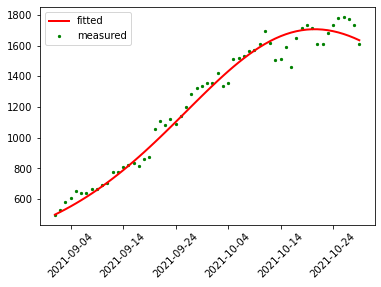

In [50]:
# fit H curve
indmin = i.index[0]
i0 = i[indmin]
d0 = d[indmin]
h0 = h[indmin]
r0 = r[indmin]
s0 = 90000

x0 = [s0,i0,d0,h0,r0]
# measured data
t_x = np.arange(0, period)
measured = [i,d,h,r]

params = Parameters()
params.add('s', value=s0, vary=False)
params.add('i', value=i0, vary=False)
params.add('d', value=d0, vary=False)
params.add('h', value=h0, vary=False)
params.add('r', value=r0, vary=False)
params.add('k0', value=0.14602347, min=0.00001, max=0.5)
params.add('k1', value=0.1, min=0.00001, max=0.7)
params.add('k2', value = 8/100, min = 1/100, max = 0.2)
params.add('k3', value = 1.5667e-04, min = 0.001/100, max = 0.1)
p_index = 3
df = fit_i()

59
59
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 100
    # data points      = 59
    # variables        = 4
    chi-square         = 4.1471e+09
    reduced chi-square = 75401423.0
    Akaike info crit   = 1074.01981
    Bayesian info crit = 1082.32996
##  Warning: uncertainties could not be estimated:
    k2:  at initial value
    k2:  at boundary
    k3:  at boundary
[[Variables]]
    s:   90000 (fixed)
    i:   1523 (fixed)
    d:   55 (fixed)
    h:   499 (fixed)
    r:   66222 (fixed)
    k0:  0.26362917 (init = 0.1860235)
    k1:  0.05932823 (init = 0.1)
    k2:  0.20000000 (init = 0.2)
    k3:  1.0000e-05 (init = 0.00015667)


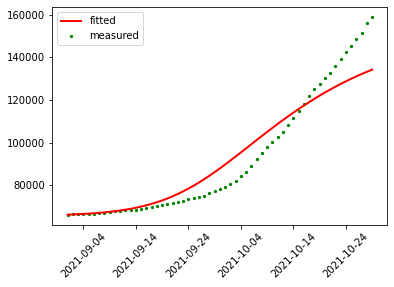

In [44]:
# fit R curve
indmin = i.index[0]
i0 = i[indmin]
d0 = d[indmin]
h0 = h[indmin]
r0 = r[indmin]
s0 = 90000

x0 = [s0,i0,d0,h0,r0]
# measured data
t_x = np.arange(0, period)
measured = [i,d,h,r]

params = Parameters()
params.add('s', value=s0, vary=False)
params.add('i', value=i0, vary=False)
params.add('d', value=d0, vary=False)
params.add('h', value=h0, vary=False)
params.add('r', value=r0, vary=False)
params.add('k0', value=0.18602347, min=0.00001, max=0.5)
params.add('k1', value=0.1, min=0.00001, max=0.7)
params.add('k2', value = 0.20000000, min = 1/100, max = 0.2)
params.add('k3', value = 1.5667e-04, min = 0.001/100, max = 0.1)
p_index = 4
df = fit_i()